In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [48]:
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

In [49]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

# Remove rows where 'value' is less than or equal to 0
df = df[df['value'] > 0]

# Remove rows where 'items' column has the value '\N'
df = df[df['items'] != r'\N']




#1. How many distinct orders are received in each month?

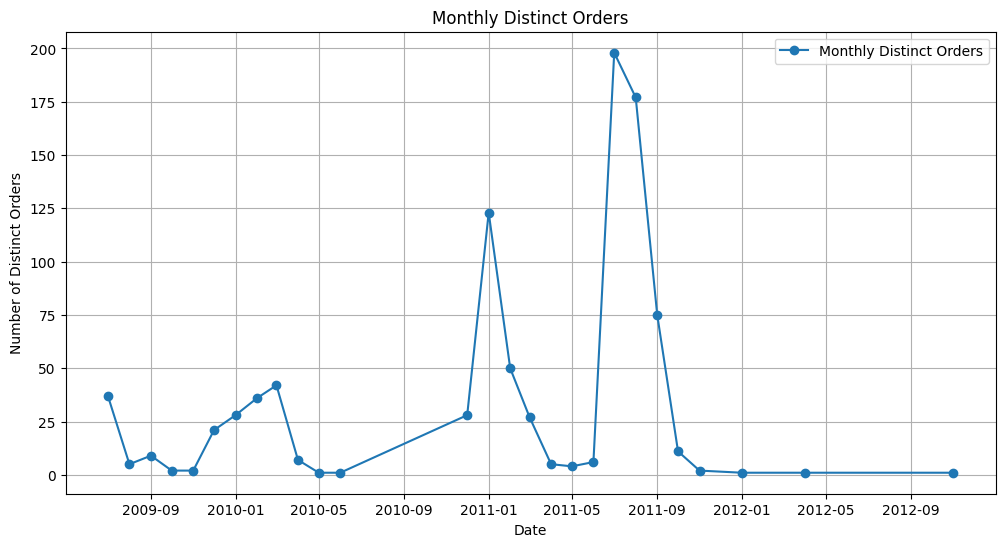

ADF Statistic: -3.59241149910783
p-value: 0.005907771862762453
                                      SARIMAX Results                                      
Dep. Variable:                 Customer Order Code   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   1.050
Date:                             Sun, 08 Dec 2024   AIC                              5.900
Time:                                     14:14:42   BIC                             -2.100
Sample:                                          0   HQIC                              -inf
                                              - 27                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5357      0.006    -91.435

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/sam/Library/Python/3.

<Figure size 1500x1000 with 0 Axes>

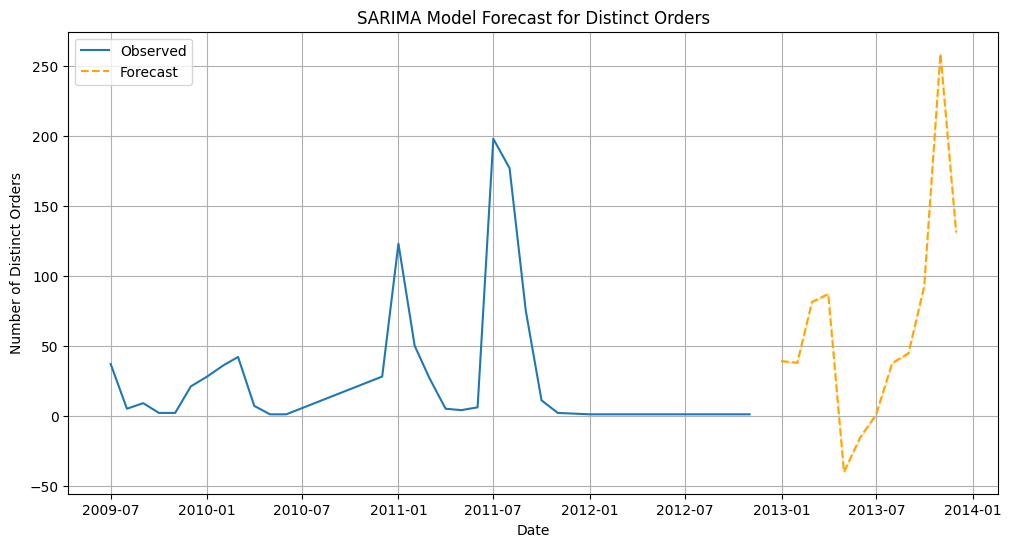

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Parse dates and extract month and year
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# Group by month and count distinct Customer Order Codes
df['Year-Month'] = df['order_date'].dt.to_period('M')
monthly_orders = df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)

# Convert to time series
monthly_orders_ts = monthly_orders.set_index('Year-Month')['Customer Order Code']

# Ensure the index is datetime for SARIMA
monthly_orders_ts.index = pd.to_datetime(monthly_orders_ts.index)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, marker='o', label='Monthly Distinct Orders')
plt.title('Monthly Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.grid(True)
plt.legend()
plt.show()

# Check stationarity using ADF test
adf_test = adfuller(monthly_orders_ts)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Differencing if not stationary
if adf_test[1] > 0.05:
    monthly_orders_diff = monthly_orders_ts.diff().dropna()
else:
    monthly_orders_diff = monthly_orders_ts

# SARIMA Model: Fitting the model
sarima_model_distinct_orders = SARIMAX(
    monthly_orders_ts, 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 0, 12),  # Seasonal order with 12-month seasonality
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarima_results_distinct_orders = sarima_model_distinct_orders.fit(disp=False)

# Model summary
print(sarima_results_distinct_orders.summary())

# Plot diagnostics
try:
    sarima_results_distinct_orders.plot_diagnostics(figsize=(15, 10))
    plt.show()
except ValueError as e:
    print("Diagnostics plot skipped due to insufficient data:", e)

# Forecast future values (12 months ahead)
forecast_steps = 12
forecast_distinct_orders = sarima_results_distinct_orders.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(
    start=monthly_orders_ts.index[-1] + pd.DateOffset(months=1), 
    periods=forecast_steps, 
    freq='M'
)
forecast_values_distinct_orders = forecast_distinct_orders.predicted_mean
forecast_ci_distinct_orders = forecast_distinct_orders.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, label='Observed')
plt.plot(forecast_index, forecast_values_distinct_orders, label='Forecast', linestyle='--', color='orange')
plt.fill_between(
    forecast_index, 
    forecast_ci_distinct_orders.iloc[:, 0], 
    forecast_ci_distinct_orders.iloc[:, 1], 
    color='orange', alpha=0.2
)
plt.title('SARIMA Model Forecast for Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.legend()
plt.grid(True)
plt.show()

# Storing the model and forecast results for Monte Carlo integration
distinct_orders_model = {
    "model": sarima_results_distinct_orders,
    "forecast": forecast_values_distinct_orders,
    "forecast_index": forecast_index,
    "confidence_interval": forecast_ci_distinct_orders
}


#2. Which items are demanded (i.e., classification-choice model)?

In [53]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Feature Engineering
# Add season column based on 'order_date'
def get_season(month):
    if month in [1, 2, 3]:
        return 'Winter'
    elif month in [4, 5, 6]:
        return 'Spring'
    elif month in [7, 8, 9]:
        return 'Summer'
    else:
        return 'Autumn'

# Parse and preprocess data
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['Season'] = df['order_date'].dt.month.apply(get_season)

# Filter the data to keep necessary columns
df_filtered = df[['Season', 'Customer Country Code', 'value', 'items', 'Route', 'Product Code']]

# Encode categorical variables (Season, Customer Country Code, and Route)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Ensure no error for unseen categories
categorical_features = ['Season', 'Customer Country Code', 'Route']
encoded_features = encoder.fit_transform(df_filtered[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Create DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine encoded features with numerical columns
numerical_features = df_filtered[['value', 'items']]
numerical_features = numerical_features.fillna(0)  # Handle missing values

# Scale numerical features
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_features.columns)

# Combine all features
df_encoded = pd.concat([scaled_numerical_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
df_encoded['Product Code'] = df_filtered['Product Code'].reset_index(drop=True)

# Prepare features (X) and target (y)
X = df_encoded.drop(['Product Code'], axis=1)
y = df_encoded['Product Code']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier: Fitting the model
rf_classifier_items = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_items.fit(X_train, y_train)

# Model Evaluation
y_pred = rf_classifier_items.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Store the model and related data for Monte Carlo simulation
item_demand_model = {
    "model": rf_classifier_items,
    "encoder": encoder,
    "scaler": scaler,
    "features": X.columns,
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "accuracy": accuracy_score(y_test, y_pred)
}


Classification Report:
              precision    recall  f1-score   support

   L10705000       0.50      0.20      0.29         5
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         3
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         5
   L10705500       0.00      0.00      0.00         3
   L10705600       0.07      0.20      0.10         5
   L10705700       0.00      0.00      0.00         2
   L10850600       0.00      0.00      0.00        13
   L10850700       0.00      0.00      0.00         3
   L10850800       0.14      0.22      0.17         9
   L10850900       0.00      0.00      0.00         5
   L10852800       0.10      0.11      0.11         9
   L10852900       0.14      0.17      0.15         6
   L10853100       0.00      0.00      0.00         1
   L12134400       0.17      0.06      0.09        17
   L12134500       0.00      0.00      0.00         8
   L

/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Use

#3. What is the quantity demanded for each item in these orders?

#4. What is the demand lead time of these orders (i.e., time elapsed from the instant when an order is received until its delivery)?


#5 After you characterize each uncertainty by predictive models, classification methods, or empirically, you can apply Monte Carlo simulation to consolidate them into total demand. 
After simulation, you must analyze simulated data and distinguish advance demand from urgent demand.

#6 At this stage, you can compare the simulated advance demand with the actual advance demand in the test set. This comparison helps you calibrate the data and improve the forecast accuracy.  After splitting the dataset into two, they were asked to report MAPE on the test data. 

#7 XYZ can reduce the production lead time to two months so that inventory decisions are based on demand forecasts with two-month horizon. What is the impact of reducing the lead time on the forecast accuracy?